In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import PIL.Image
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, BatchNormalization, Dense, Flatten, Input, Concatenate, Dense, GlobalAveragePooling2D, Activation, Reshape, Multiply, experimental, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


**preprocessing stage**

In [ ]:
train = '/content/drive/MyDrive/Datasets/CXI Dataset/data_upload_v3/train'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224,224),
    batch_size=32)

Found 2426 files belonging to 2 classes.
Using 1941 files for training.


In [ ]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224,224),
    batch_size=32)

Found 2426 files belonging to 2 classes.
Using 485 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['covid', 'non']

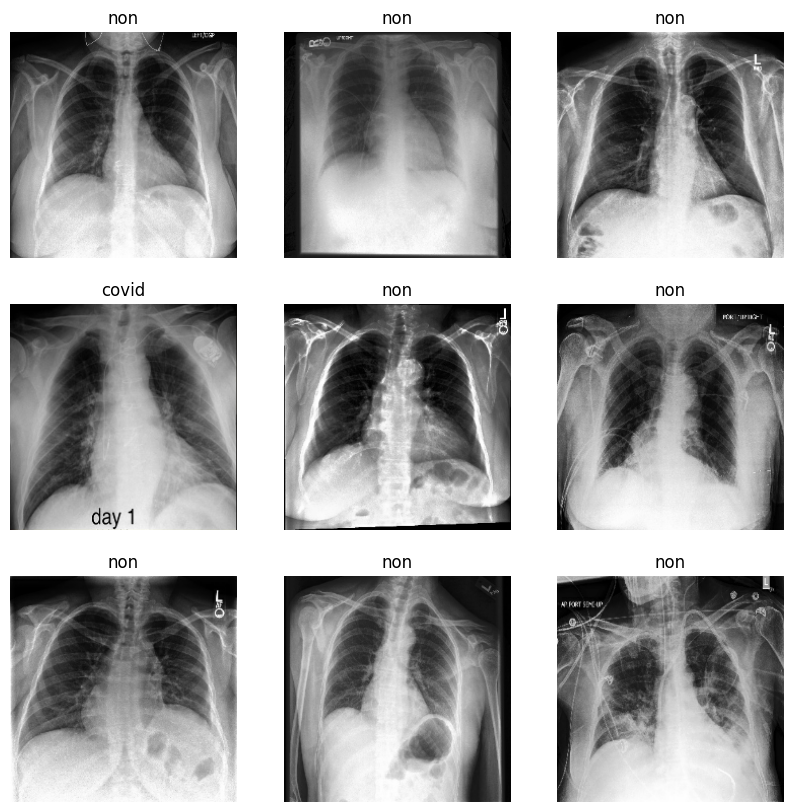

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(6):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    # print(labels_batch.shape)
    break

(32, 224, 224, 3)


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch[0].numpy())

[[[18.52551   18.52551   18.52551  ]
  [16.280613  16.280613  16.280613 ]
  [14.857142  14.857142  14.857142 ]
  ...
  [ 2.7857141  2.7857141  2.7857141]
  [ 3.290813   3.290813   3.290813 ]
  [ 2.7857141  2.7857141  2.7857141]]

 [[18.357143  18.357143  18.357143 ]
  [16.        16.        16.       ]
  [14.857142  14.857142  14.857142 ]
  ...
  [ 2.         2.         2.       ]
  [ 2.         2.         2.       ]
  [ 2.         2.         2.       ]]

 [[18.357143  18.357143  18.357143 ]
  [16.        16.        16.       ]
  [14.862245  14.862245  14.862245 ]
  ...
  [ 1.9948992  1.9948992  1.9948992]
  [ 2.         2.         2.       ]
  [ 1.9438758  1.9438758  1.9438758]]

 ...

 [[16.        16.        16.       ]
  [15.954093  15.954093  15.954093 ]
  [15.862262  15.862262  15.862262 ]
  ...
  [13.928589  13.928589  13.928589 ]
  [14.357147  14.357147  14.357147 ]
  [15.785736  15.785736  15.785736 ]]

 [[16.637764  16.637764  16.637764 ]
  [16.357147  16.357147  16.357147 ]


In [ ]:
def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]

    #Squeeze Process
    squeeze = GlobalAveragePooling2D()(input_tensor)

    #Excitation Process
    excitation = Dense(channels//ratio, activation='relu')(squeeze)

    excitation = Dense(channels, activation='sigmoid')(excitation)

    excitation = Reshape((1,1,channels))(excitation)

    #Scale the inputs with the excitation weights
    scaled_input = Multiply()([input_tensor,excitation])

    return scaled_input

**loading alexnet**

In [ ]:
# Loading alexnet
alexnet = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/pre-trained /alexnet.h5')

# model summary
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 54, 54, 96)        384       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       6

In [ ]:
# Removing the output layer
alexnet = tf.keras.Model(inputs=alexnet.input, outputs=alexnet.layers[-4].output)

#model summary
alexnet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_input (InputLaye  [(None, 224, 224, 3)]     0         
 r)                                                              
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 54, 54, 96)        384       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0     

In [ ]:
for layer in alexnet.layers:
    layer.trainable = False

**midsnet model**

In [ ]:
def MIDSNET():
    input = Input((224, 224, 3))
    x = alexnet(input, training=False)

    x = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(input)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)


    # Multiscale feature extraction layer
    branch1 = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)
    branch1 = tf.image.resize(branch1, [56, 56])

    branch2 = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)
    branch2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(branch2)
    branch2 = tf.image.resize(branch2, [56, 56])

    branch3 = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)
    branch3 = Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(branch3)
    branch3 = tf.image.resize(branch3, [56, 56])

    branch4 = MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid')(x)
    branch4 = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(branch4)
    branch4 = tf.image.resize(branch4, [56, 56])

    merged_features = tf.keras.layers.concatenate([branch1, branch2, branch3, branch4], axis=3)

    num_layers = 4
    GROWTH_RATE = 12
    for i in range(num_layers):
        if i == 0:
            x = BatchNormalization()(merged_features)
        else:
            x = BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)
        x = BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
        x = Conv2D(filters=20, kernel_size=(1, 1), activation='relu')(x)
        if i != 3:
            x = squeeze_excite_block(x)

    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = AveragePooling2D(pool_size=(1, 1), strides=1)(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)

    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = AveragePooling2D(pool_size=(7, 7), strides=1)(x)
    x = Flatten()(x)

    x = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=input, outputs=x)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = MIDSNET()
model.summary()
model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 tf.nn.relu (TFOpLambda)     (None, 112, 112, 16)         0         ['batch_normalization[0]

In [ ]:
#Unfreezing the last layers of alexnet
for layer in alexnet.layers[-4:]:
    layer.trainable = True

In [ ]:
#Recompiling the model
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            save_best_only=True)

csv_logger = CSVLogger('training.log')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=validation_ds, callbacks=[reduce_lr, model_checkpoint_callback, early_stopping])

Epoch 1/50
61/61 [==============================] - 213s 3s/step - loss: 0.5642 - accuracy: 0.8042 - val_loss: 0.6929 - val_accuracy: 0.8701 - lr: 1.0000e-05
Epoch 2/50
61/61 [==============================] - 16s 237ms/step - loss: 0.3635 - accuracy: 0.8794 - val_loss: 0.6928 - val_accuracy: 0.8701 - lr: 1.0000e-05
Epoch 3/50
61/61 [==============================] - 16s 249ms/step - loss: 0.2933 - accuracy: 0.8764 - val_loss: 0.6927 - val_accuracy: 0.8680 - lr: 1.0000e-05
Epoch 4/50
61/61 [==============================] - 20s 303ms/step - loss: 0.2677 - accuracy: 0.8753 - val_loss: 0.6925 - val_accuracy: 0.8557 - lr: 1.0000e-05
Epoch 5/50
61/61 [==============================] - 19s 294ms/step - loss: 0.2554 - accuracy: 0.8717 - val_loss: 0.6910 - val_accuracy: 0.8124 - lr: 1.0000e-05
Epoch 6/50
61/61 [==============================] - 16s 238ms/step - loss: 0.2479 - accuracy: 0.8758 - val_loss: 0.6833 - val_accuracy: 0.8536 - lr: 1.0000e-05
Epoch 7/50
61/61 [========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


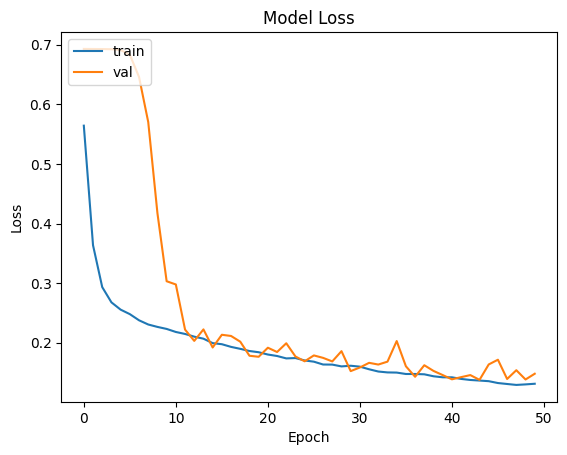

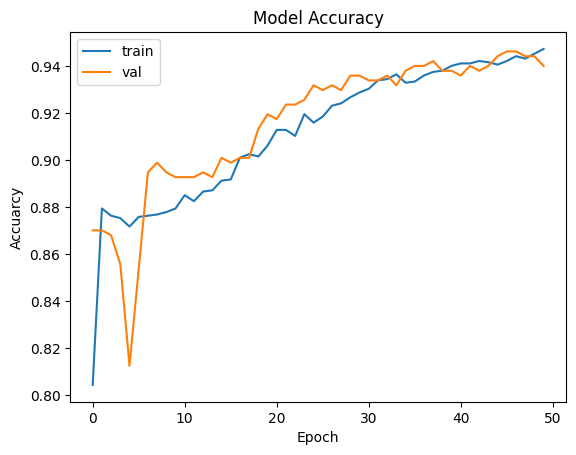

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()